<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5506-pipeline/blob/main/statcan_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex -q
!pip install statsmodels==0.14.0 -q
!pip install tslearn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.0 MB/s eta 0:00:00


In [41]:
# file handling & general
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

# eda
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats

# pca
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import DBSCAN

# preprocessing & ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, silhouette_score

#
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# clustering
from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Extract, Transform, Load pipeline

Stats can has tools to make http requests for date from their cube. [1]

In [3]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

I was able to make a request for a single vector, but needed help with transforming the XML output that was extracted. I spent a lot of time trying to write a loop to extract and parse multiple vectors, and ended up using a code generator [2] for the following StatCanETL class:

In [8]:
# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}


In [9]:
class StatCanETL:
    def __init__(self, table_df):
        '''initialize with df of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''transform the XML response into a structured DataFrame.'''
        # parse XML content
        root = ET.fromstring(xml_content)

        # locate the series element
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        # extract obs
        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # convert date format if quarterly or yearly
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        # convert to df
        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''convert quarterly date string (YYYY-Qx) to a standard date format (YYYY-MM)'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''load df into object named name_df.'''
        variable_name = f'{name}_df'
        globals()[variable_name] = df
        self.data_objects[variable_name] = df
        print(f'Data for {name} saved to object {variable_name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')

In [10]:
# define table metadata
tables = {
    'name': ['wage', 'rmpi', 'cpi'],
    'tableid': [14100223, 18100268, 18100004],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seasonally adjusted, 2002 = 100'],
    'vector': ['v79311153', 'v1230998135', 'v41690973'],
    'vectdesc': ['', '', ''],
    'description': ['', '', ''],
    'frequency': ['monthly', 'monthly', 'monthly'],
    'start': ['2001-01', '2001-01', '2001-01'], # if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12']
}

# make df
table_df = pd.DataFrame(tables)

In [11]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage_df
Processing rmpi...
Data for rmpi saved to object rmpi_df
Processing cpi...
Data for cpi saved to object cpi_df


## EDA and cleaning

**check to see if the data loaded correctly:**

In [12]:
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3))

wage_df
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14
rmpi_df
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5
cpi_df
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1


Rename columns

In [13]:
wage_df.rename(columns = {'Value': 'wage',
                          'Date': 'date'},
               inplace = True)
rmpi_df.rename(columns = {'Value': 'rmpi',
                          'Date': 'date'},
               inplace = True)
cpi_df.rename(columns={'Value': 'cpi',
                       'Date': 'date'},
               inplace = True)

Merge tables

In [14]:
data = wage_df.merge(rmpi_df, on = 'date', how = 'outer') \
              .merge(cpi_df, on = 'date', how = 'outer')

In [15]:
print(data)
print(data.info())

        date     wage   rmpi    cpi
0    2001-01   657.14   65.2   96.3
1    2001-02   653.59   65.8   96.8
2    2001-03   655.14   65.5   97.1
3    2001-04   652.44   65.2   97.8
4    2001-05   652.28   65.3   98.6
..       ...      ...    ...    ...
283  2024-08  1274.25  139.3  161.8
284  2024-09  1277.70  134.8  161.1
285  2024-10  1284.24  140.3  161.8
286  2024-11  1285.91  140.2  161.8
287  2024-12      NaN  142.0  161.2

[288 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    288 non-null    object 
 1   wage    287 non-null    float64
 2   rmpi    288 non-null    float64
 3   cpi     288 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.1+ KB
None


At the time of writing, wage was missing one observation from 2024-12. I assume this is because it may take a while for the data to be processed each month. I'll use forward fill to deall with that missing value. If quarterly data was pulled from the data cube, there would be missing data for the months 02-03, 05-06, 08-09, and 11-12. Forward fill could also deal with those missing observations.

In [16]:
data = data.ffill()

In [17]:
# date correct dtype, format
data['date'] = pd.to_datetime(data['date'],
                              format = '%Y-%m')

In [18]:
# descriptive stats
data.describe()

,date,wage,rmpi,cpi
count,288,288.000000,288.000000,288.000000
mean,2012-12-15 17:00:00,911.631250,99.128125,123.738542
min,2001-01-01 00:00:00,652.280000,55.300000,96.300000
25%,2006-12-24 06:00:00,772.157500,84.075000,109.775000
50%,2012-12-16 12:00:00,903.520000,97.050000,122.200000
75%,2018-12-08 18:00:00,1009.597500,112.725000,134.225000
max,2024-12-01 00:00:00,1285.910000,166.600000,162.100000
std,NaN,170.097978,24.307042,17.143681


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    288 non-null    datetime64[ns]
 1   wage    288 non-null    float64       
 2   rmpi    288 non-null    float64       
 3   cpi     288 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 9.1 KB


In [20]:
data.head(3)

,date,wage,rmpi,cpi
0,2001-01-01,657.14,65.2,96.3
1,2001-02-01,653.59,65.8,96.8
2,2001-03-01,655.14,65.5,97.1


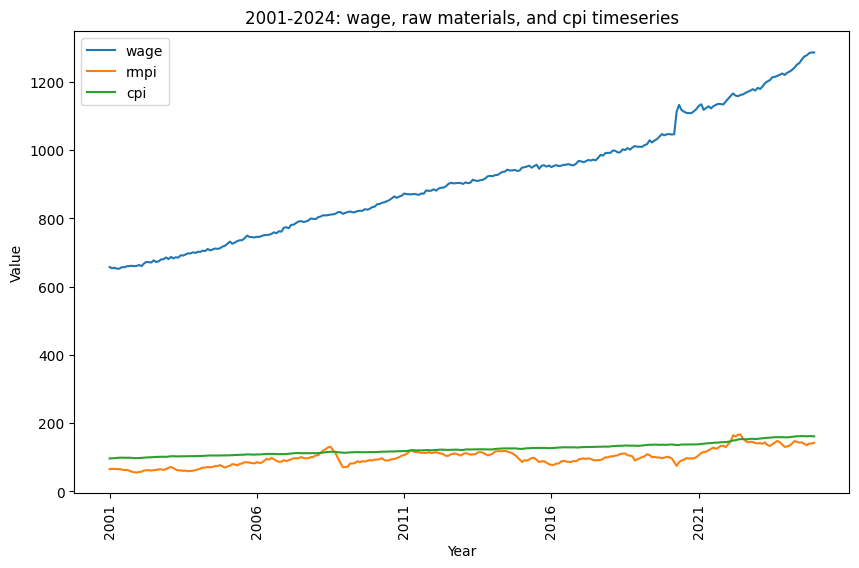

In [21]:
# plot raw data
plt.figure(figsize=(10, 6))

for var in data.columns[1:]:
    plt.plot(data['date'], data[var], label = var)

    plt.xlabel('Year')
    x_tick_labels = [d.year for d in data['date'][::60]]
    plt.xticks(data['date'][::60], x_tick_labels, rotation=90)

    plt.ylabel('Value')

    plt.title('2001-2024: wage, raw materials, and cpi timeseries')
    plt.legend()


Here we can see that cpi and rmpi, both indexed, are fairly close in magnitude. Wages, however, are very large. I'll create my own index to make it more easily comparable to rmpi and cpi.



In [22]:
# index wage
base_wage = data.loc[data['date'] == '2002-01', 'wage'].values[0]

# 'new' feature
data['wage'] = (data['wage'] / base_wage) * 100

In [23]:
data.describe()

,date,wage,rmpi,cpi
count,288,288.000000,288.000000,288.000000
mean,2012-12-15 17:00:00,137.469841,99.128125,123.738542
min,2001-01-01 00:00:00,98.360854,55.300000,96.300000
25%,2006-12-24 06:00:00,116.437835,84.075000,109.775000
50%,2012-12-16 12:00:00,136.246701,97.050000,122.200000
75%,2018-12-08 18:00:00,152.242705,112.725000,134.225000
max,2024-12-01 00:00:00,193.909372,166.600000,162.100000
std,NaN,25.650000,24.307042,17.143681


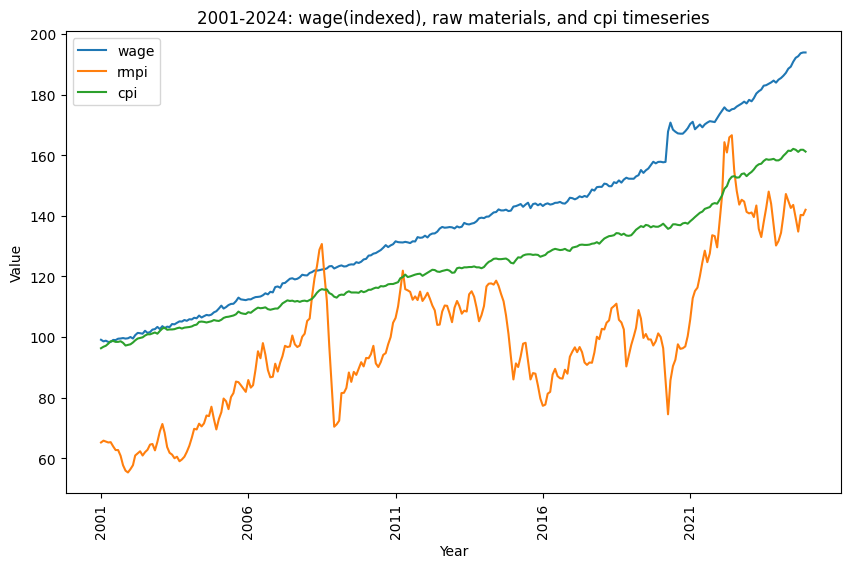

In [24]:
# plot indexed data
plt.figure(figsize=(10, 6))

for var in data.columns[1:]:
    plt.plot(data['date'], data[var], label = var)

    plt.xlabel('Year')
    x_tick_labels = [d.year for d in data['date'][::60]]
    plt.xticks(data['date'][::60], x_tick_labels, rotation=90)

    plt.ylabel('Value')

    plt.title('2001-2024: wage(indexed), raw materials, and cpi timeseries')
    plt.legend()

In [25]:
# categorize variables
numerical_vars = ['wage', 'rmpi', 'cpi']

### Augmented Dickey-Fuller (ADF) test for stationary time series

In [26]:
# adf test
adf_results_list = []
for feature in numerical_vars:
    adf_results = adfuller(data[feature])
    adf_results_list.append([feature,
                             adf_results[0],
                             adf_results[1],
                             adf_results[4]['5%'],
                             adf_results[4]['10%']])

adf_results_df = pd.DataFrame(adf_results_list, columns=['variable',
                                                         'ADF Statistic',
                                                         'p-value',
                                                         '5%',
                                                         '10%'])
adf_results_df

,variable,ADF Statistic,p-value,5%,10%
0,wage,2.425141,0.999022,-2.872031,-2.572360
1,rmpi,-1.854706,0.353659,-2.871699,-2.572183
2,cpi,0.725756,0.990338,-2.872108,-2.572401


With the ADF test, the null hypothesis is that the time series has a root unit - this means it is non-stationary. The alternative hypothesis is that the time series is stationary. Given the very large p-values above, we fail to reject the null hypothesis: the time series for all 5 variables have a root unit.


I'll try some transformations to see if I can make them stationary, as some time series models like ARIMA assume a stationary time series.

Scaling the data has made it easier to compare the changes to the respective variables with each other, but the overall patterns have been preserved. More transforming is required to achieve stationary data. Differencing will compute the differences between consecutive obervations, so that seasonality and trends are reduced and the variance is stabilized.

In [27]:
# differencing

# new df
diff_df = {'date': data['date']}

# diff cols
for var in numerical_vars:
    diff_df[var + '_diff'] = data[var].diff()

diff_df = pd.DataFrame(diff_df)

# drop na rows
diff_df.dropna(inplace = True)

diff_df.head(3)

,date,wage_diff,rmpi_diff,cpi_diff
1,2001-02-01,-0.535324,0.6,0.5
2,2001-03-01,0.233733,-0.3,0.3
3,2001-04-01,-0.407148,-0.3,0.7


In [28]:
diff_vars = ['wage_diff', 'rmpi_diff', 'cpi_diff']

# another adf test
adf_results_list2 = []
for feature in diff_vars:
    adf_results2 = adfuller(diff_df[feature])
    adf_results_list2.append([feature,
                              adf_results2[0],
                              adf_results2[1],
                              adf_results2[4]['5%'],
                              adf_results2[4]['10%']])

adf_results_df2 = pd.DataFrame(adf_results_list2,
                               columns = ['variable',
                                          'ADF Statistic',
                                          'p-value',
                                          '5%',
                                          '10%'])
adf_results_df2

,variable,ADF Statistic,p-value,5%,10%
0,wage_diff,-4.572952,1.448384e-04,-2.872031,-2.572360
1,rmpi_diff,-9.002268,6.449738e-15,-2.871808,-2.572241
2,cpi_diff,-2.956486,3.916281e-02,-2.872108,-2.572401


Given the very small p-values from the second ADF test, we now have evidence of stationary time series. What does stationarity in time series data look like? I'll create some more visualizations for each decade of the timeseries, as well as visualizing some major economic events: the recession around 2008, and the more recent recession from the COVID-19 pandemic.

In [29]:
decade_2001_2010 = diff_df[diff_df['date'].between('2001-01-01', '2010-12-01')]
decade_2011_2020 = diff_df[diff_df['date'].between('2011-01-01', '2020-12-01')]
decade_2015_2024 = diff_df[diff_df['date'].between('2015-01-01', '2024-12-01')]

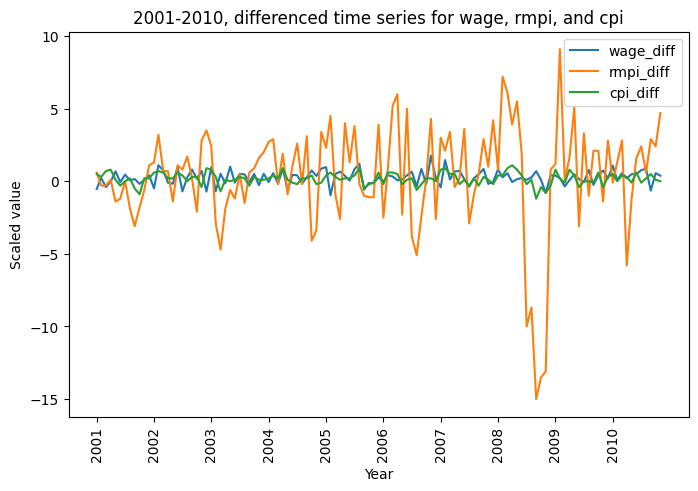

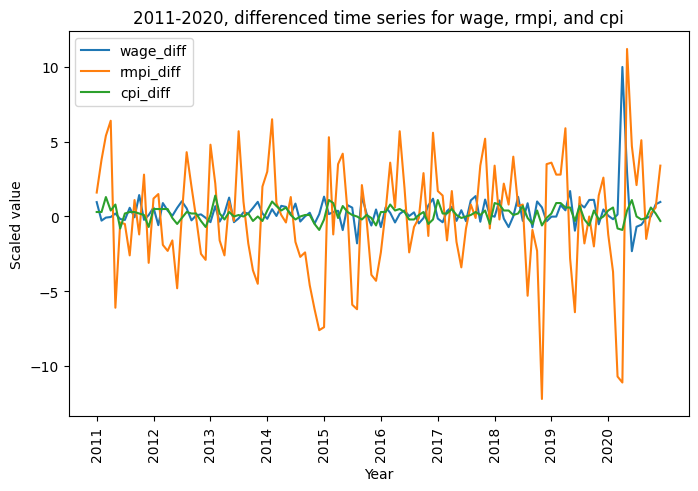

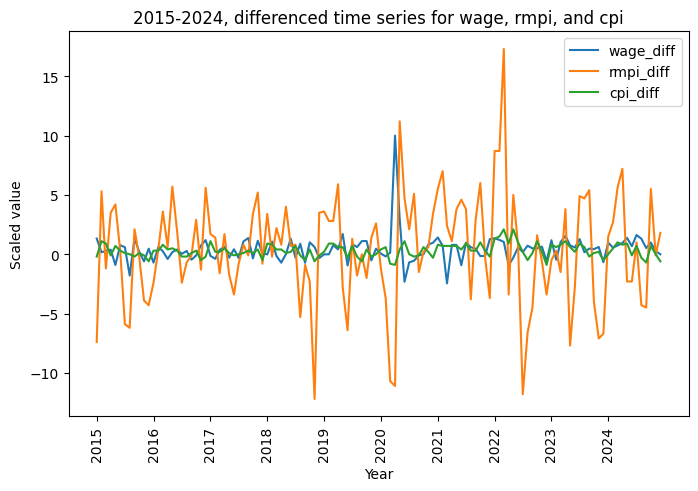

In [31]:
decades = {'2001-2010': decade_2001_2010,
           '2011-2020': decade_2011_2020,
           '2015-2024': decade_2015_2024}

for decade_name, decade_data in decades.items():
    plt.figure(figsize = (8, 5))

    for var in diff_vars:
        plt.plot(decade_data['date'],
                 decade_data[var],
                 label = var)

        plt.xlabel('Year')
        x_tick_labels = [d.year for d in decade_data['date'][::12]]
        plt.xticks(decade_data['date'][::12], x_tick_labels, rotation = 90)

        plt.ylabel('Scaled value')

        plt.title(f'{decade_name}, differenced time series for wage, rmpi, and cpi')
        plt.legend()

In [32]:
# recession events
recession_1 = diff_df[diff_df['date'].between('2007-01-01', '2010-12-01')] # I remember that... fun times!
recession_2 = diff_df[diff_df['date'].between('2019-01-01', '2023-12-01')] # also fun times!
stable = diff_df[diff_df['date'].between('2009-07-01', '2018-06-30')]

# ref: https://www.thecanadianencyclopedia.ca/en/article/recession

_Tangent: I remember sitting down at the bank to apply for a line of credit near the end of the Stable Period defined above. When asked if I wanted a fixed or floating interest rate, I picked the floating rate._

_Me: "Interest rates and the economy have been stable for a while, only an unforseen SUPER HUGE MASSIVE SHOCK TO THE GLOBAL MARKETS could drive up interest rates quickly". Oh, how we laughed that day..._

_COVID-19 pandemic: "Hold my beer"_  

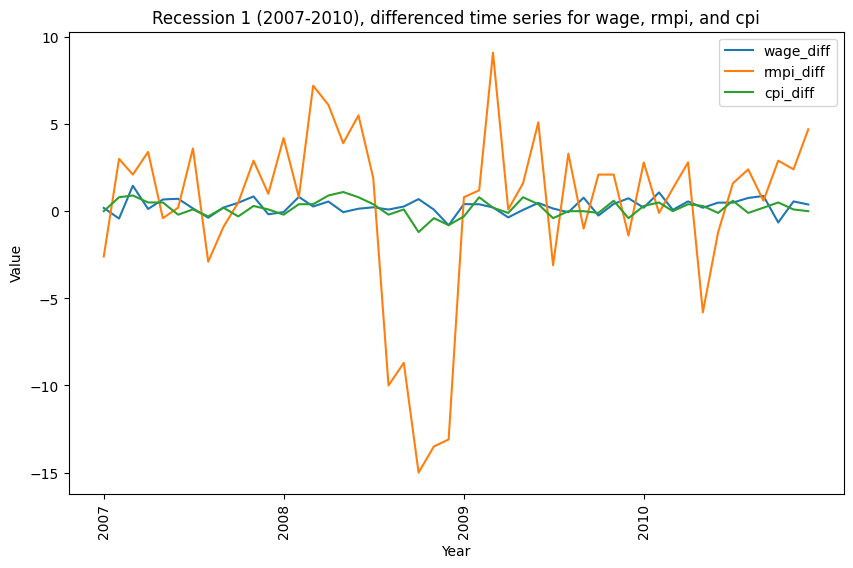

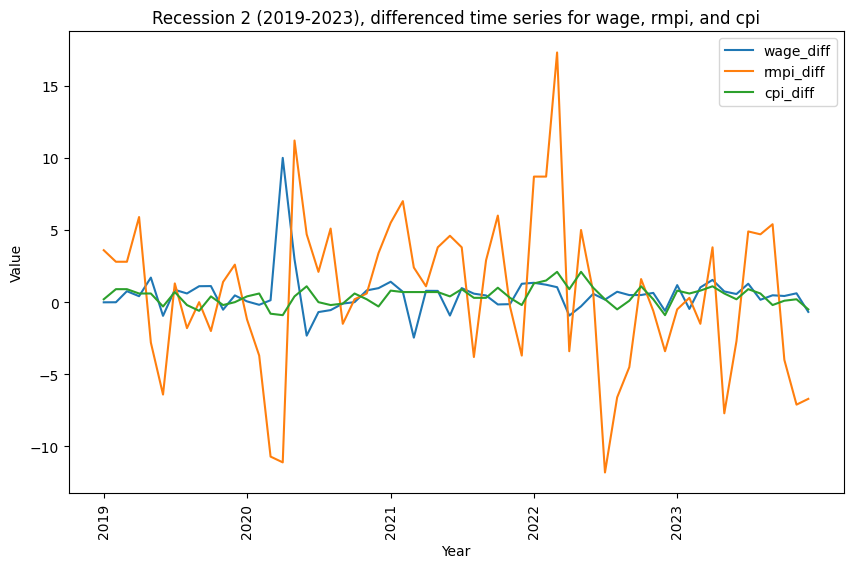

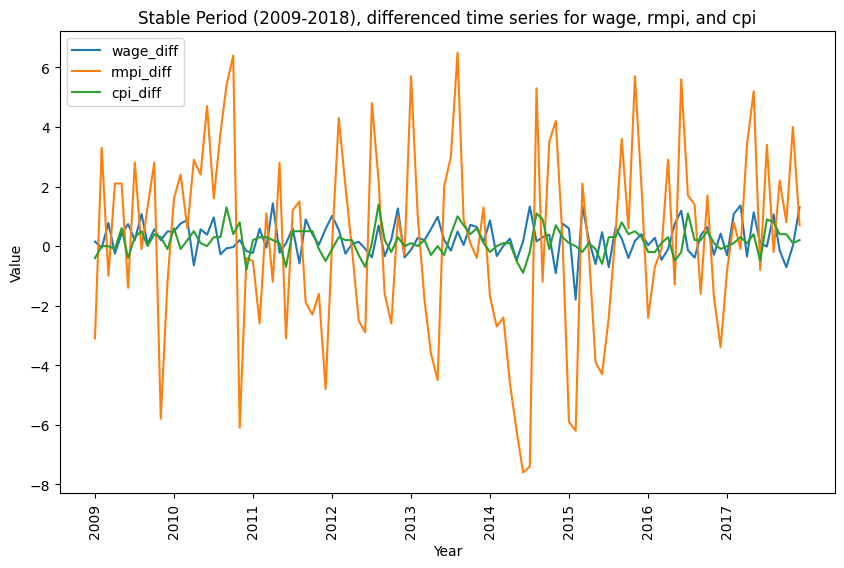

In [34]:
events = {'Recession 1 (2007-2010)': recession_1,
          'Recession 2 (2019-2023)': recession_2,
          'Stable Period (2009-2018)': stable}

for event_name, event_df in events.items():
    plt.figure(figsize = (10, 6))

    for var in diff_vars:
        plt.plot(event_df['date'],
                 event_df[var],
                 label = var)
        plt.xlabel('Year')
        x_tick_labels = [d.year for d in event_df['date'][::12]]
        plt.xticks(event_df['date'][::12],
                   x_tick_labels,
                   rotation = 90)
        plt.ylabel('Value')
        plt.title(f'{event_name}, differenced time series for wage, rmpi, and cpi')
        plt.legend()
    plt.show()

### Autocorrelation and partial autocorrelation

Next, I'll perform autocorrelation analysis to understand the correlation of each time series with its own lagged values. This will help to identify seasonality, perhaps the cyclical nature of the economy, other trends, and the persistence of values over time.

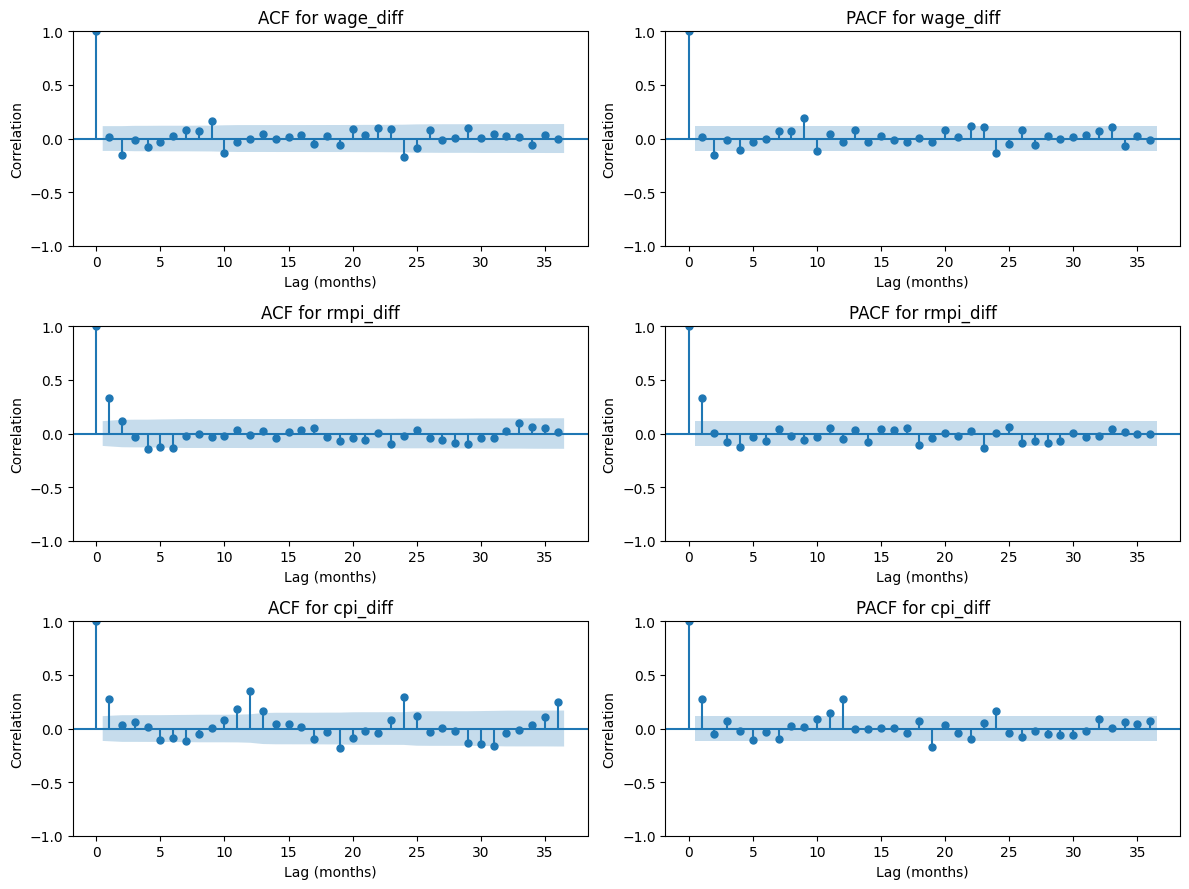

In [35]:
# acf & pcf
fig, axes = plt.subplots(len(diff_vars),
                         2,
                         figsize = (12, 9))
axes = axes.ravel()

for i, var in enumerate(diff_vars):
    # acf
    plot_acf(diff_df[var],
             lags = 36,
             ax = axes[i * 2])

    axes[i * 2].set_title(f'ACF for {var}')
    axes[i * 2].set_xlabel('Lag (months)')
    axes[i * 2].set_ylabel('Correlation')

    # pcf
    plot_pacf(diff_df[var],
              lags = 36,
              ax = axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'PACF for {var}')
    axes[i * 2 + 1].set_xlabel('Lag (months)')
    axes[i * 2 + 1].set_ylabel('Correlation')

plt.tight_layout()
plt.show()


ACF plots: visualize how each current data point is related to it's past values. The x-axis represents the time difference in months between each point.The very first point (lag = 0) is compared to itself and always has a correlation of 1.0, the second point (lag = 1) compares the current point to the value from 1 month ago, and so on. The shaded blue band shows the confidence interval - if a point falls outside the band, it is considered statistically significant.

The PCF plot is similar to the ACF plot, except is focuses on the direct relationship between the current and previous points, removing the influence of the intermediate lags.


*   Wage series: we see statistically significant correlations at lag = [2, 9, maybe 10, 24] points, meaning that each current value is affected by the values from 2, 9, 10, and 24 months prior.
*   RMPI series: we see statistically significant correlations at lag = [1, 4] points, meaning that each current value is affected by the values from 1 and 4 months prior.
*   CPI series: the seasonal fluctuation is apparent in the ACF plot - there are statistically significant high correlation points at the lag = [1, 12, 24, 36] points, and (almost) statistically significant low correlation points at the lag = [ 7, 19, 31] points. When creating an ARIMA model of CPI, these lag points will be useful in deciding on the model structure.



### Correlation and cross-correlation

Now I'll take a look at how these series correlate with each other.

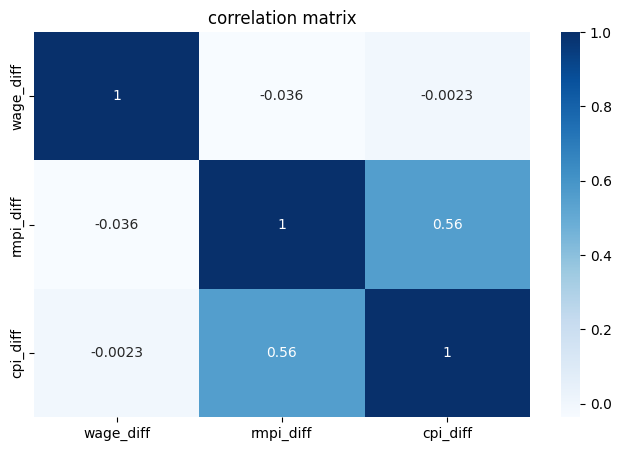

In [ ]:
cor_matrix = diff_df[diff_vars].corr()

plt.figure(figsize = (8, 5))
sns.heatmap(cor_matrix,
            annot = True,
            cmap = 'Blues')
plt.title('correlation matrix')
plt.show()

The cross-correlation measures the similarity between the features and the target as a function of lag on one, relative to the other. It can indicate how much one time series leads or lags another. Where there are negative cross-correlations, the two series are moving in opposite directions; where there are positive correlations, the two series are moving in the same direction.

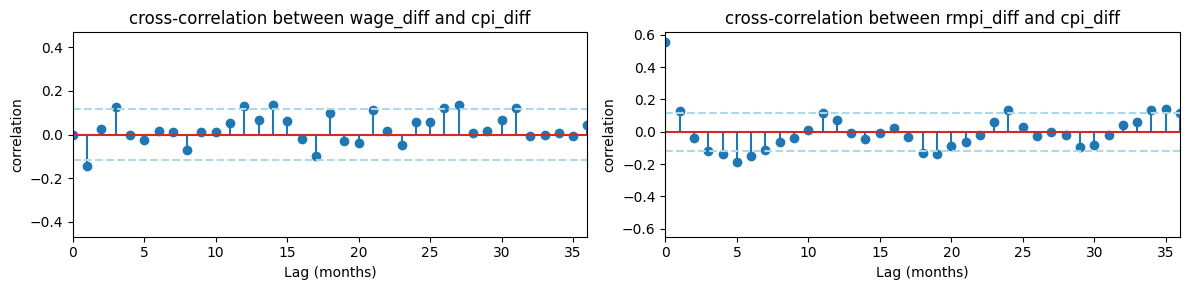

In [36]:
# ccf
x = ['wage_diff', 'rmpi_diff']
y = 'cpi_diff'

# side by side plots
fig, axes = plt.subplots(1,
                         len(x),
                         figsize = (12, 3))

for i, var in enumerate(x):
  ccf_results = sm.tsa.stattools.ccf(diff_df[var],
                                     diff_df[y])

  # conf int
  n = len(diff_df[var])
  conf_level = 0.95
  lower, upper = stats.norm.interval(conf_level,
                                     loc = 0,
                                     scale = 1/np.sqrt(n))

  axes[i].stem(ccf_results)
  axes[i].set_title(f'cross-correlation between {var} and {y}')
  axes[i].set_xlabel('Lag (months)')
  axes[i].set_ylabel('correlation')
  axes[i].set_xlim(0, 36)

  axes[i].axhline(y = lower,
                  color = 'lightblue',
                  linestyle = '--',
                  label = f'{conf_level * 100:.0f}% Confidence Interval')
  axes[i].axhline(y = upper,
                  color = 'lightblue',
                  linestyle = '--')

plt.tight_layout()
plt.show()




* wage_diff and cpi_dff:lag = [1, 3, 12, 14, 26, 27, 31]

*   rmpi_diff and cpi_diff: there again seems to be a seasonal fluctuation between rmpi and cpi, with statistically significant correlations at _approximately_ 12 month intervals. This may indicate that it takes approximately one year for raw materials pricing to affect the cpi. Further investigation would be needed to substantiate this.



### Conduct Granger Causality Testing!!!

Conduct a Granger causality test to investigate the direction of causality between raw_diff and cpi_diff. This can help to determine whether changes in raw material prices truly "cause" changes in the CPI, or if there's a more complex relationship.


The matrix above shows that there is little collinearity between the features wage_diff and rmpi_diff.

I also see that wage_diff has little to do with cpi_diff, it may be that this feature will not be used in some models.


### Principal component analysis



At an earlier stage of creating this project, I had another 2 variables in the dataset: productivity and tax rates.
* Productivity showed significant collinearity with wages, and nearly no correlation with cpi.
* Taxes showed very little correlation to cpi.

I had conducted PCA to create a new set of variables that did not have any collinearity. I have since removed those features from the ETL pipeline, so at this point PCA is not neccesary.

In [ ]:
#trf_features = ['wage_diff', 'productivity_diff', 'tax_diff', 'rmpi_diff']

In [ ]:
# pca = PCA(n_components = 3)
# XPC = pca.fit_transform(data[trf_features])

# pca_cols = [f'PC{i+1}' for i in range(pca.n_components)]

# print('explained variance ratio:', pca.explained_variance_ratio_)
# print('singular values:', pca.singular_values_)
# print('shape of xpc:', XPC.shape)

~~I performed the PCA on the scaled and transformed data so that the results would reflect the relationships between the features, rather than the trends or seasonality. PC1 - PC4 creates a new set of variables which themselves are combinations of the original variables. PC1 captures 36.6% of the overall variance, PC2 captures 35.1%, and so on.~~

### Clustering

Seeing that wages show little correlation with the cpi, I decided to do clustering with just rmpi and cpi. Lets see what the optimal number of clusters is.

In [ ]:
X = diff_df['rmpi_diff'].values
y = diff_df['cpi_diff'].values


X_reshaped = X.reshape(X.shape[0],
                       1,
                       1)

# no of clusters
cluster_range = range (2, 11)

# inertias and silh scores
inertias = []
silhouette_scores = []

# loop
for n_clusters in cluster_range:

    # init
    km = TimeSeriesKMeans(n_clusters = n_clusters,
                          metric = 'dtw',
                          max_iter = 10,
                          random_state = 5506)

    # fit
    labels = km.fit_predict(X_reshaped)

    # eval
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_reshaped.reshape(X_reshaped.shape[0],
                                                                 X_reshaped.shape[1]),
                                              labels))

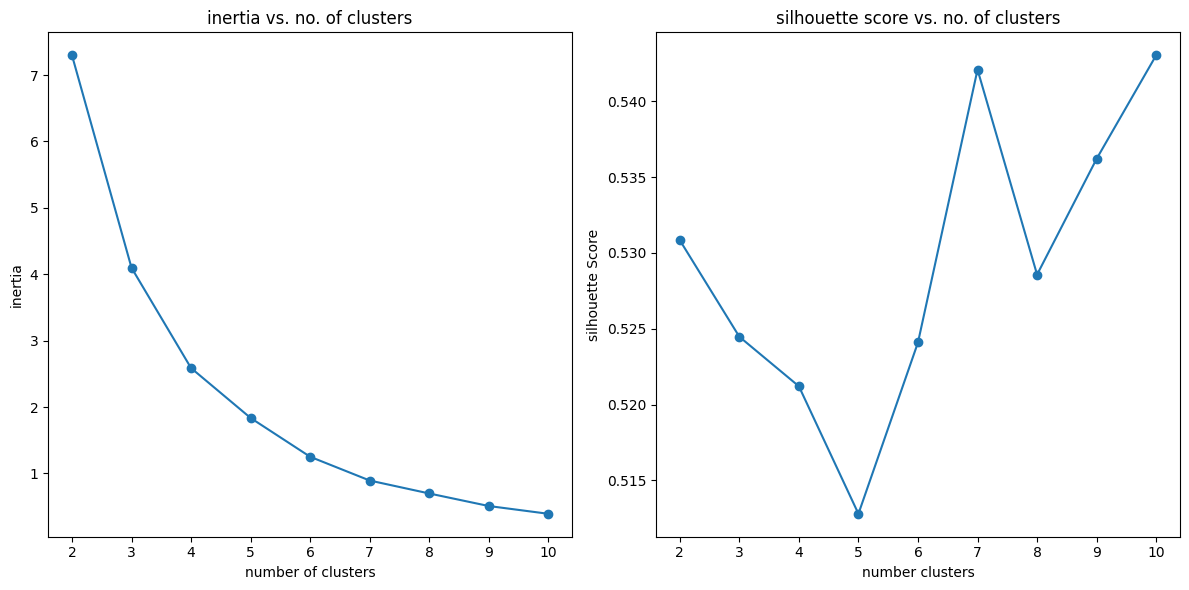

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#  plot inertias
ax1.plot(cluster_range, inertias, marker='o')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia')
ax1.set_title('inertia vs. no. of clusters')

# plot silhouette scores
ax2.plot(cluster_range, silhouette_scores, marker='o')
ax2.set_xlabel('number clusters')
ax2.set_ylabel('silhouette Score')
ax2.set_title('silhouette score vs. no. of clusters')

plt.tight_layout()
plt.show()

The inertia plot reveals that the inertia decreases from 7 (with 2 clusters) down to approx. 0.5 (with 10 clusters). There is not a clear 'elbow point' on this plot, but given its shape I might pick 6 clusters. The silhouette scor plot reveals that the lowest score occurs when there are 5 clusters. Given the 2 plots, I will pick 5 as the number of clusters to use.

In [54]:
# fit 5 clusters
km_5 = TimeSeriesKMeans(n_clusters = 5,
                         metric = 'dtw',
                         max_iter = 10,
                         random_state = 5506)

# get labels
labels_5 = km_5.fit_predict(X_reshaped)

# add to df
diff_df['cluster'] = labels_5

diff_df.head(10)

,date,wage_diff,rmpi_diff,cpi_diff,cluster
1,2001-02-01,-0.535324,0.6,0.5,0
2,2001-03-01,0.233733,-0.3,0.3,4
3,2001-04-01,-0.407148,-0.3,0.7,4
4,2001-05-01,-0.024127,0.1,0.8,4
5,2001-06-01,0.683103,-1.4,0.1,4
6,2001-07-01,-0.057302,-1.2,-0.3,4
7,2001-08-01,0.458418,0.0,0.0,4
8,2001-09-01,0.064842,-1.9,0.2,4
9,2001-10-01,0.152303,-3.1,-0.5,1
10,2001-11-01,-0.179447,-1.8,-0.9,4


<Figure size 1000x600 with 0 Axes>

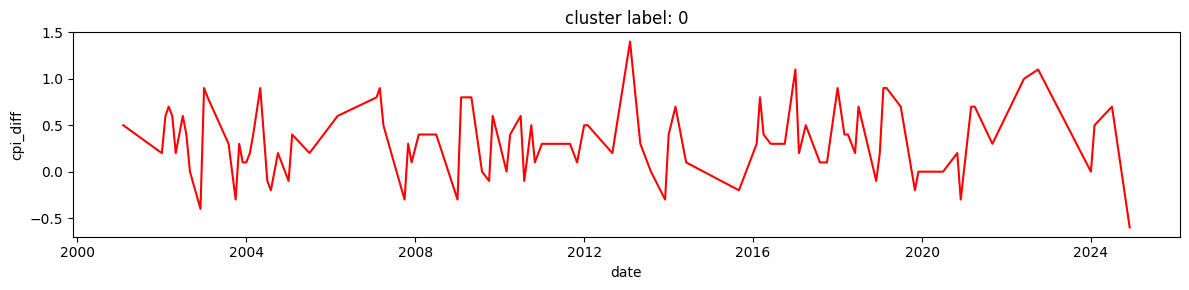

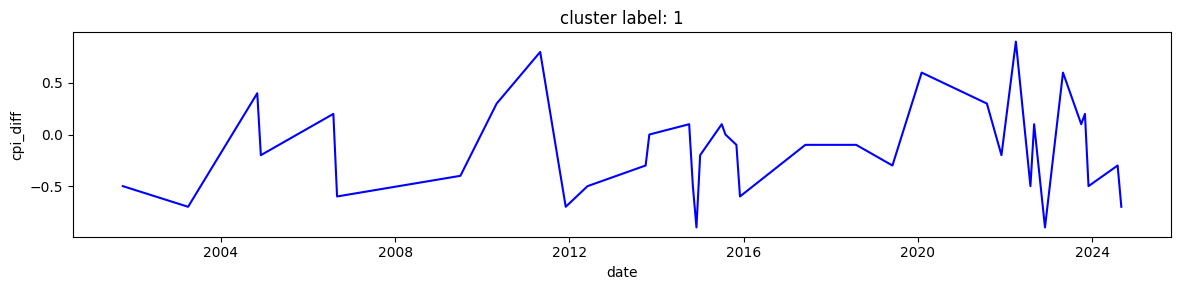

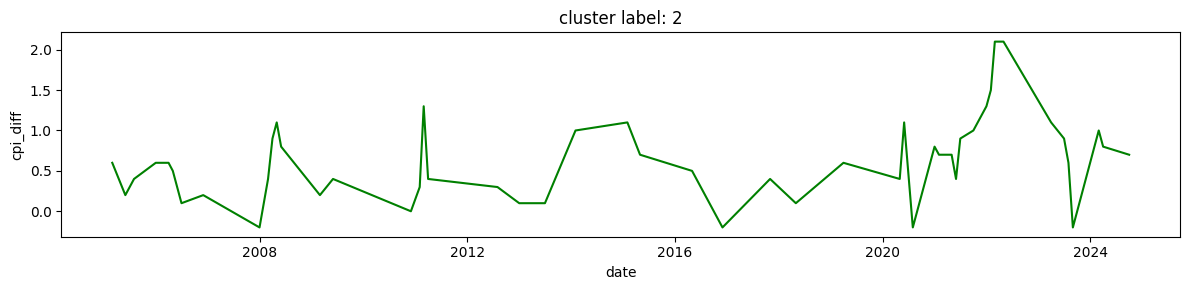

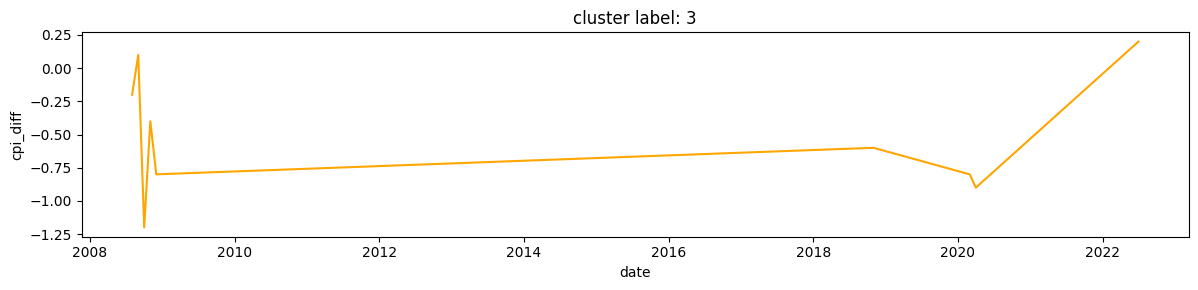

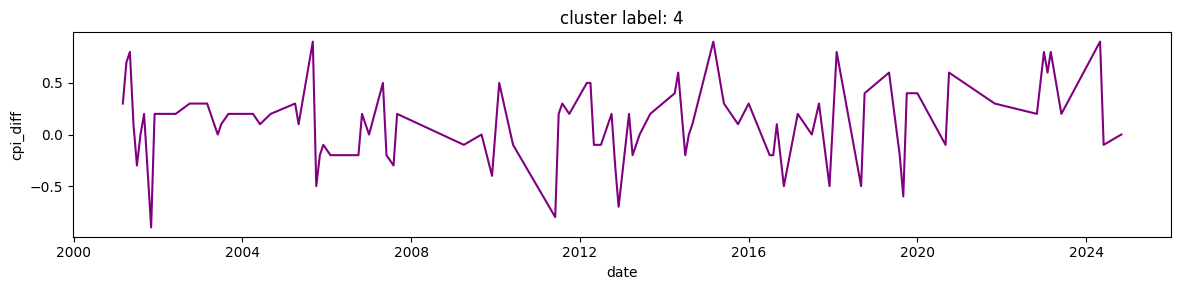

In [63]:
colours = ['red',
           'blue',
           'green',
           'orange',
           'purple']

# Plot time series for each cluster
plt.figure(figsize=(10, 6))

for cluster in range(5):

    cluster_data = diff_df[diff_df['cluster'] == cluster]

    plt.figure(figsize = (12, 3))

    plt.plot(cluster_data['date'],
             cluster_data['cpi_diff'],
             color = colours[cluster],
             label = f'cluster {cluster}')

    plt.xlabel('date')
    plt.ylabel('cpi_diff')
    plt.title(f'cluster label: {cluster}')

    plt.tight_layout()
    plt.show()

There are some interesting patterns that emerge when the clusters are visualized. I find cluster label 3 interesting - it has me wondering if it is picking up on the 2 recession events with the period of stability that I had defined above. Given the limited scope of the project, I will not analyze these clusters further, but have made a note about further study.

## Modeling

### Linear regression

To create a linear regression model, the date can be converted to an ordinal value to be used as a predictor variable.

In [64]:
# make ordinal date value
ref_date = diff_df['date'].min()
diff_df['date_ordinal'] = (diff_df['date'] - ref_date).dt.days

In [65]:
diff_df

,date,wage_diff,rmpi_diff,cpi_diff,cluster,date_ordinal
1,2001-02-01,-0.535324,0.6,0.5,0,0
2,2001-03-01,0.233733,-0.3,0.3,4,28
3,2001-04-01,-0.407148,-0.3,0.7,4,59
4,2001-05-01,-0.024127,0.1,0.8,4,89
5,2001-06-01,0.683103,-1.4,0.1,4,120
...,...,...,...,...,...,...
283,2024-08-01,1.305889,-4.3,-0.3,1,8582
284,2024-09-01,0.520244,-4.5,-0.7,1,8613
285,2024-10-01,0.986202,5.5,0.7,2,8643
286,2024-11-01,0.251828,-0.1,0.0,4,8674


In [66]:
# split data
train_df = diff_df[(diff_df['date'] >= '2009-07-01') & (diff_df['date'] <= '2015-06-30')].copy()
test_df = diff_df[(diff_df['date'] >= '2015-07-01') & (diff_df['date'] <= '2018-06-30')].copy()

In [70]:
X_train = train_df[['rmpi_diff', 'date_ordinal']]
y_train = train_df['cpi_diff']
X_test = test_df[['rmpi_diff', 'date_ordinal']]
y_test = test_df['cpi_diff']

In [78]:
model = LinearRegression()

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# eval
mse = mean_squared_error(y_test, y_pred)
print(f'mse: {mse}')

mse: 0.12932367636965378


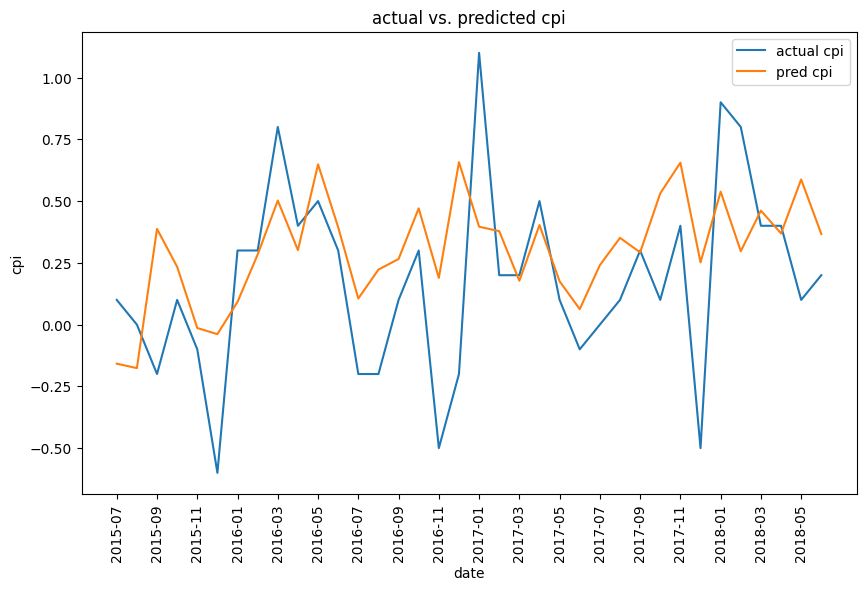

In [85]:
# plot actual vs pred
plt.figure(figsize=(10, 6))

# years for xaxis lab
x_tick_labels = test_df['date'].dt.strftime('%Y-%m')

plt.plot(range(len(y_test)),
         y_test.values,
         label = 'actual cpi')
plt.plot(range(len(y_test)),
         y_pred,
         label = 'pred cpi')

plt.xlabel('date')
plt.xticks(range(len(y_test))[::2],
           x_tick_labels[::2],
           rotation = 90)

plt.ylabel('cpi')
plt.title('actual vs. predicted cpi')
plt.legend()
plt.show()


Well, its not terrible. I feel like the model is picking up some of overall pattern of the actual differenced cpi target.

### ARIMA

The ARIMA model predicts..... based the series own....

I've taken the significant points from the ACF and PCF plots to use in the grid search for the optimal p, d, and q values.

In [ ]:
# def features / target
train_arima = train_df['cpi_diff']
test_arima = test_df['cpi_diff']

In [ ]:
# parameters taken from the ACF plot significant points
p_values = [0, 1, 7, 12, 19, 21]
d_values = [0]
q_values = [0, 1, 7, 12, 19, 24]


# Define a function to evaluate the model
def evaluate_arima_model(train_data, order):
    """
    Fits an ARIMA model with the given order and returns the RMSE.
    """
    try:
        model = ARIMA(train_arima, order=order)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_arima), end=len(train_arima) + len(test_arima) - 1)
        rmse = np.sqrt(mean_squared_error(test_arima, predictions))
        return rmse
    except:
        return np.inf  # Return infinity for invalid models

# Perform grid search
best_score, best_order = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                rmse = evaluate_arima_model(train_arima, order)
                if rmse < best_score:
                    best_score, best_order = rmse, order
                print(f"ARIMA{order} RMSE={rmse:.3f}")
            except:
                continue

# Evaluate the model (example: RMSE)
rmse = np.sqrt(mean_squared_error(test_arima, predictions))
print(f'RMSE: {rmse}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_arima.index, test_arima, label='Actual')
plt.plot(test_arima.index, predictions, label='Predicted')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ARIMA(0, 0, 0) RMSE=0.372
ARIMA(0, 0, 1) RMSE=0.372


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(0, 0, 7) RMSE=0.370


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(0, 0, 12) RMSE=0.370


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(0, 0, 19) RMSE=0.383


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(0, 0, 24) RMSE=0.370
ARIMA(1, 0, 0) RMSE=0.372
ARIMA(1, 0, 1) RMSE=0.372


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

ARIMA(1, 0, 7) RMSE=0.384


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(1, 0, 12) RMSE=0.375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(1, 0, 19) RMSE=0.387


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(1, 0, 24) RMSE=0.370


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

ARIMA(7, 0, 0) RMSE=0.372


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

ARIMA(7, 0, 1) RMSE=0.401


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(7, 0, 7) RMSE=0.460


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(7, 0, 12) RMSE=0.405


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(7, 0, 19) RMSE=0.508


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(7, 0, 24) RMSE=0.409


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

ARIMA(12, 0, 0) RMSE=0.385
ARIMA(12, 0, 1) RMSE=inf


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA(12, 0, 7) RMSE=inf


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(12, 0, 12) RMSE=inf


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

ARIMA(12, 0, 19) RMSE=0.485
ARIMA(12, 0, 24) RMSE=inf


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

ARIMA(19, 0, 0) RMSE=0.431


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(19, 0, 1) RMSE=0.439
ARIMA(19, 0, 7) RMSE=inf


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

ARIMA(19, 0, 12) RMSE=0.474


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473

ARIMA(19, 0, 19) RMSE=0.507


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predi

ARIMA(19, 0, 24) RMSE=0.501


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

ARIMA(21, 0, 0) RMSE=0.434
ARIMA(21, 0, 1) RMSE=inf


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(21, 0, 7) RMSE=inf


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# prompt: please create an RNN model using the principle components to predict the cpi_diff

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Assuming X_train, y_train, X_test, and y_test are defined as in the provided code.
# and pca_cols contains the names of the principal components

# Fit an RNN model to each principal component (example using a simple ARIMA model)
rnn_models = {}
predictions = {}
for col in pca_cols:
  # You would replace ARIMA with your preferred RNN model here.
  # The order (p,d,q) in ARIMA should be tuned based on the data.
  rnn_models[col] = ARIMA(endog=y_train, exog=X_train[col], order=(1, 0, 0)).fit()
  predictions[col] = rnn_models[col].predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test[col])


# Combine predictions (e.g., averaging)
combined_pred = pd.DataFrame(predictions).mean(axis=1)

# Evaluate the model
mse = mean_squared_error(y_test, combined_pred)
print(f'Mean Squared Error: {mse}')


## Discussion

### Further study


*   Clustering analysis
*   List item



## References

1. [Statistics Canada SDMX userguide](https://www.statcan.gc.ca/en/developers/sdmx/user-guide)
2. [OpenAI](https://chatgpt.com/)
3. [sklearn documentation](https://scikit-learn.org/1.6/)
4. [Towards Data Science: PCA Analysis](https://towardsdatascience.com/the-pca-trick-with-time-series-d40d48c69d28)